In [1]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df =  pd.read_csv('loan_data.csv')
df.drop('Loan_ID', axis = 1, inplace= True)
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
376,Male,Yes,3+,Graduate,No,5703,0.0,128.0,360.0,1.0,Urban,Y
377,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,1.0,Rural,Y
378,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
379,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y


In [3]:
df.count()

Gender               376
Married              381
Dependents           373
Education            381
Self_Employed        360
ApplicantIncome      381
CoapplicantIncome    381
LoanAmount           381
Loan_Amount_Term     370
Credit_History       351
Property_Area        381
Loan_Status          381
dtype: int64

есть пропущенные значения, удалим наблюдения с пропущенными значениями

In [4]:
df.dropna(inplace=True)
df.reset_index(drop= True, inplace=True)
df.count()

Gender               308
Married              308
Dependents           308
Education            308
Self_Employed        308
ApplicantIncome      308
CoapplicantIncome    308
LoanAmount           308
Loan_Amount_Term     308
Credit_History       308
Property_Area        308
Loan_Status          308
dtype: int64

потеряли 20% данных - не критично

отнормируем и закодируем данные

In [5]:
df.nunique()

Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      267
CoapplicantIncome    153
LoanAmount            96
Loan_Amount_Term       9
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64

In [6]:
bin_cols = list(df.nunique()[df.nunique() == 2].index)
bin_cols

['Gender',
 'Married',
 'Education',
 'Self_Employed',
 'Credit_History',
 'Loan_Status']

In [7]:
df['Gender'] = df['Gender'].apply(lambda x: 0 if x == 'Male' else 1)
df['Education'] = df['Education'].apply(lambda x: 0 if x == 'Not Graduate' else 1)
df['Married'] = df['Married'].apply(lambda x: 0 if x == 'No' else 1)
df['Self_Employed'] = df['Self_Employed'].apply(lambda x: 0 if x == 'No' else 1)
df['Loan_Status'] = df['Loan_Status'].apply(lambda x: 0 if x == 'N' else 1)


In [8]:
df = df.astype({'Gender': 'float64','Education':'float64','Married':'float64','Self_Employed':'float64','Loan_Status':'float64'})
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0.0,1.0,1,1.0,0.0,4583,1508.0,128.0,360.0,1.0,Rural,0.0
1,0.0,1.0,0,1.0,1.0,3000,0.0,66.0,360.0,1.0,Urban,1.0
2,0.0,1.0,0,0.0,0.0,2583,2358.0,120.0,360.0,1.0,Urban,1.0
3,0.0,0.0,0,1.0,0.0,6000,0.0,141.0,360.0,1.0,Urban,1.0
4,0.0,1.0,0,0.0,0.0,2333,1516.0,95.0,360.0,1.0,Urban,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
303,0.0,1.0,3+,1.0,0.0,5703,0.0,128.0,360.0,1.0,Urban,1.0
304,0.0,1.0,0,1.0,0.0,3232,1950.0,108.0,360.0,1.0,Rural,1.0
305,1.0,0.0,0,1.0,0.0,2900,0.0,71.0,360.0,1.0,Rural,1.0
306,0.0,1.0,3+,1.0,0.0,4106,0.0,40.0,180.0,1.0,Rural,1.0


In [9]:
cat_cols = ['Dependents','Property_Area']
non_num_cols = cat_cols.copy()
non_num_cols.extend(bin_cols)
num_cols = df.drop(non_num_cols,axis =1).columns

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',OneHotEncoder() ,cat_cols),
        ('num', StandardScaler(), num_cols),
        ('bin','passthrough',bin_cols)
    ])

In [11]:
df_shuffled = df.sample(len(df),random_state= 66).reset_index(drop=True)
df_train = df_shuffled[:int(len(df)*0.75)]
df_test = df_shuffled[int(len(df)*0.75):]

In [12]:
display(df_train,df_test)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0.0,1.0,0,1.0,0.0,2425,2340.0,143.0,360.0,1.0,Semiurban,1.0
1,0.0,1.0,0,1.0,0.0,5829,0.0,138.0,360.0,1.0,Rural,1.0
2,0.0,1.0,1,0.0,0.0,2600,2500.0,90.0,360.0,1.0,Semiurban,1.0
3,0.0,1.0,3+,1.0,0.0,7740,0.0,128.0,180.0,1.0,Urban,1.0
4,1.0,1.0,0,0.0,0.0,1928,1644.0,100.0,360.0,1.0,Semiurban,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
226,0.0,1.0,0,1.0,0.0,2083,3150.0,128.0,360.0,1.0,Semiurban,1.0
227,0.0,1.0,3+,0.0,0.0,3522,0.0,81.0,180.0,1.0,Rural,0.0
228,0.0,1.0,1,1.0,0.0,1625,1803.0,96.0,360.0,1.0,Urban,1.0
229,0.0,1.0,0,1.0,1.0,3000,0.0,66.0,360.0,1.0,Urban,1.0


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
231,0.0,1.0,2,1.0,0.0,3900,0.0,90.0,360.0,1.0,Semiurban,1.0
232,0.0,0.0,0,1.0,0.0,4000,2500.0,140.0,360.0,1.0,Rural,1.0
233,0.0,1.0,1,1.0,1.0,1000,3022.0,110.0,360.0,1.0,Urban,0.0
234,1.0,0.0,0,1.0,0.0,3180,0.0,71.0,360.0,0.0,Urban,0.0
235,0.0,1.0,2,1.0,0.0,4009,1717.0,116.0,360.0,1.0,Semiurban,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
303,0.0,0.0,0,1.0,0.0,2500,20000.0,103.0,360.0,1.0,Semiurban,1.0
304,0.0,1.0,0,0.0,0.0,3406,4417.0,123.0,360.0,1.0,Semiurban,1.0
305,0.0,1.0,2,0.0,0.0,3273,1820.0,81.0,360.0,1.0,Urban,1.0
306,0.0,1.0,2,1.0,0.0,5819,5000.0,120.0,360.0,1.0,Rural,1.0


In [13]:
train_norm = preprocessor.fit_transform(df_train)
test_norm = preprocessor.transform(df_test)
train_norm.shape,test_norm.shape

((231, 17), (77, 17))

In [14]:
col_names = []
for item in preprocessor.get_feature_names_out():
    col_names.append(item.split('__')[1])
col_names

['Dependents_0',
 'Dependents_1',
 'Dependents_2',
 'Dependents_3+',
 'Property_Area_Rural',
 'Property_Area_Semiurban',
 'Property_Area_Urban',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Gender',
 'Married',
 'Education',
 'Self_Employed',
 'Credit_History',
 'Loan_Status']

In [15]:
df_train_norm = pd.DataFrame(train_norm,columns=col_names)
df_test_norm = pd.DataFrame(test_norm,columns=col_names)
display(df_train_norm,df_test_norm)

,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender,Married,Education,Self_Employed,Credit_History,Loan_Status
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.821442,0.451448,1.344918,0.307814,0.0,1.0,1.0,0.0,1.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.466699,-0.473763,1.170557,0.307814,0.0,1.0,1.0,0.0,1.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.703808,0.514710,-0.503306,0.307814,0.0,1.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.751258,-0.473763,0.821835,-2.293593,0.0,1.0,1.0,0.0,1.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.155521,0.176257,-0.154585,0.307814,1.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.051331,0.771713,0.821835,0.307814,0.0,1.0,1.0,0.0,1.0,1.0
227,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.084047,-0.473763,-0.817156,-2.293593,0.0,1.0,0.0,0.0,1.0,0.0
228,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.359195,0.239124,-0.294073,0.307814,0.0,1.0,1.0,0.0,1.0,1.0
229,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.434931,-0.473763,-1.340238,0.307814,0.0,1.0,1.0,1.0,1.0,1.0


,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender,Married,Education,Self_Employed,Credit_History,Loan_Status
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.170041,-0.473763,-0.503306,0.307814,0.0,1.0,1.0,0.0,1.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.237260,0.514710,1.240301,0.307814,0.0,0.0,1.0,0.0,1.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.779315,0.721103,0.194137,0.307814,0.0,1.0,1.0,1.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.313937,-0.473763,-1.165877,0.307814,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.243310,0.205120,0.403370,0.307814,0.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.771027,7.434023,-0.049968,0.307814,0.0,0.0,1.0,0.0,1.0,1.0
73,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.162021,1.272671,0.647475,0.307814,0.0,1.0,0.0,0.0,1.0,1.0
74,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.251423,0.245845,-0.817156,0.307814,0.0,1.0,0.0,0.0,1.0,1.0
75,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.459977,1.503183,0.542858,0.307814,0.0,1.0,1.0,0.0,1.0,1.0


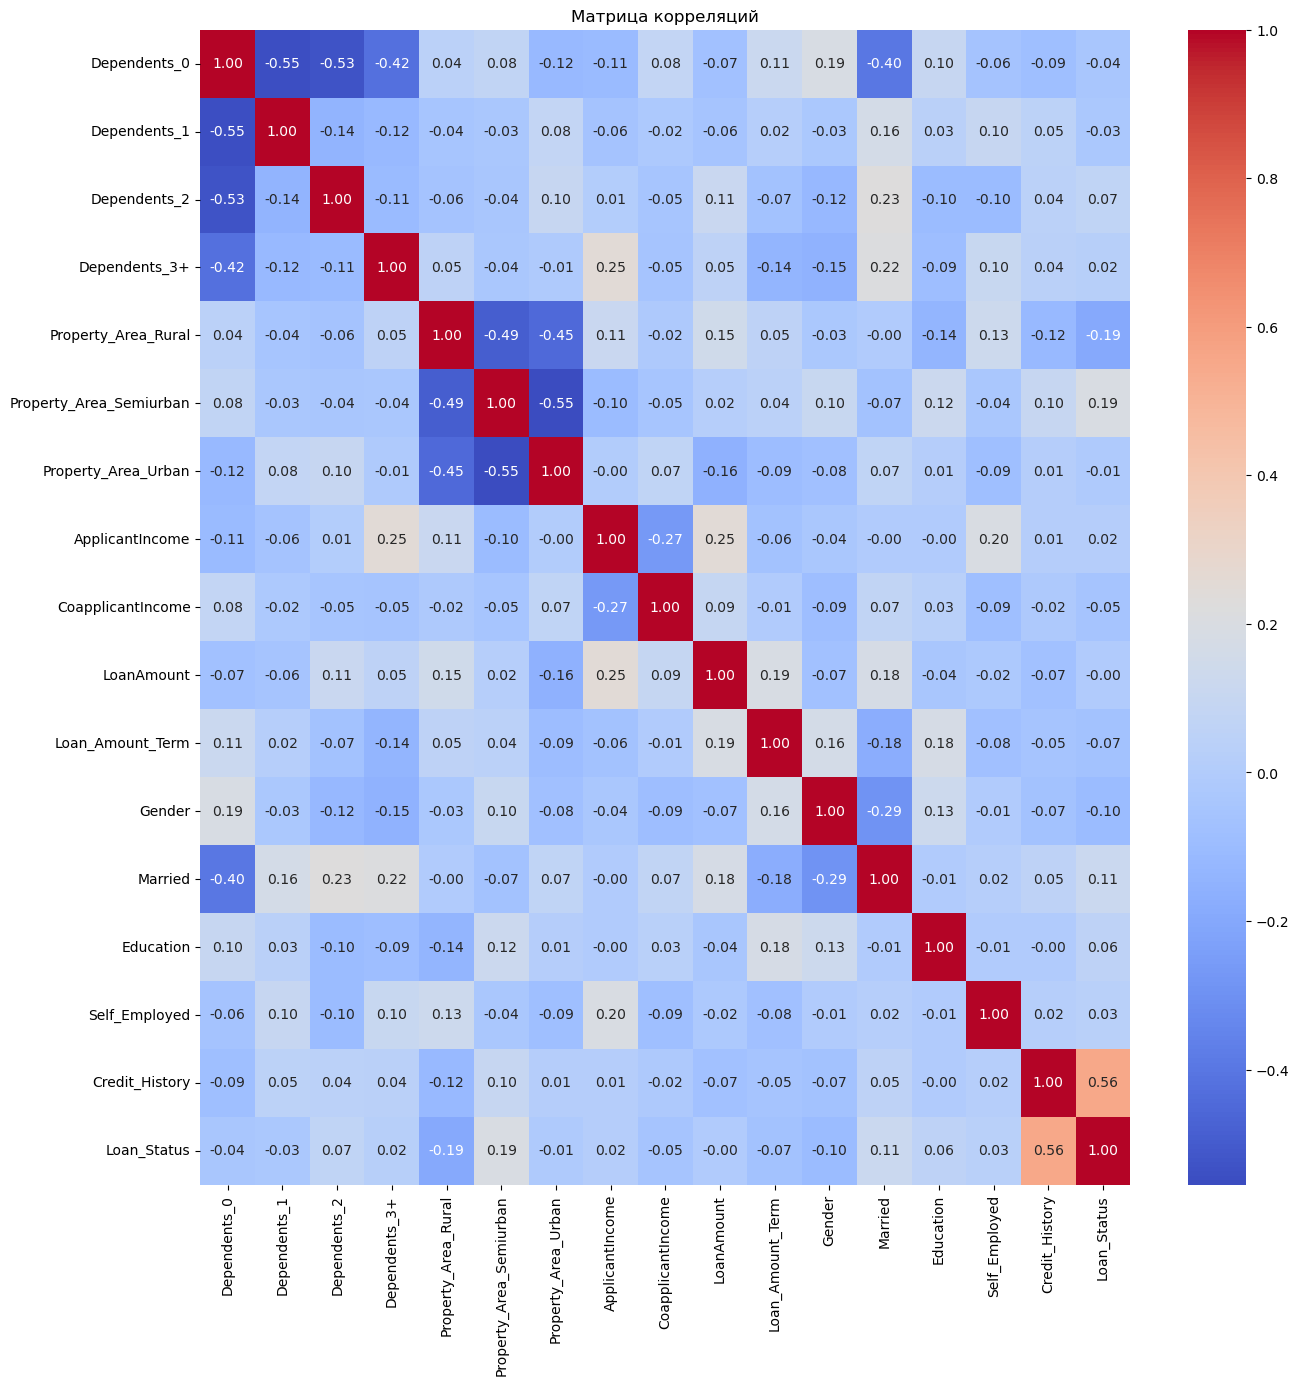

In [16]:
correlation_matrix = df_train_norm.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций')
plt.show()

In [17]:
print(df_train_norm['Loan_Status'].value_counts(normalize= True))
print(df_test_norm['Loan_Status'].value_counts(normalize= True))

Loan_Status
1.0    0.701299
0.0    0.298701
Name: proportion, dtype: float64
Loan_Status
1.0    0.74026
0.0    0.25974
Name: proportion, dtype: float64


есть дисбаланс классов

построим модели без устранения дисбаланса и сравним с моделями обученными на данных без дисбаланса

In [18]:
X_train = df_train_norm.drop('Loan_Status',axis = 1)
X_test = df_test_norm.drop('Loan_Status',axis = 1)
y_train = df_train_norm['Loan_Status']
y_test = df_test_norm['Loan_Status']

In [19]:
param_grid = {
        'n_estimators': [25,50,75,100],
        'max_depth': [5,7,10,15,30],
        'min_samples_leaf': [1,3,5,7],
        'criterion': ['gini','entropy'],
        'bootstrap': [True, False]
    }

In [20]:
X_grid = pd.concat([X_train, X_test], ignore_index=True)
y_grid = pd.concat([y_train, y_test], ignore_index=True)

grid_search = GridSearchCV(RandomForestClassifier(random_state=1, n_jobs=-1), param_grid, cv=([(list(range(len(X_train))), list(range(len(X_train), len(X_grid))))]), 
                           scoring='f1')

In [21]:
grid_search.fit(X_grid, y_grid)

GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
                   243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
                   255, 256, 257, 258, 259, 260, ...])],
             estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 10, 15, 30],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'n_estimators': [25, 50, 75, 100]},
             scoring='f1')

In [22]:
grid_search.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [23]:
grid_search.best_score_

0.9344262295081968

In [24]:
best_model = grid_search.best_estimator_
best_model

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=1)

In [25]:
from sklearn.metrics import f1_score, accuracy_score

In [26]:
preds_tree = best_model.predict(X_test)

In [27]:
f1_score(y_test,preds_tree)

0.9344262295081968

In [28]:
accuracy_score(y_test,preds_tree)

0.8961038961038961

---
исправляем дисбаланс классов

In [29]:
from imblearn.over_sampling import SMOTE

In [30]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train,y_train)

In [31]:
y_res.value_counts(normalize=True)

Loan_Status
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64

In [32]:
X_res_grid = pd.concat([X_res, X_test], ignore_index=True)
y_res_grid = pd.concat([y_res, y_test], ignore_index=True)

grid_search_r = GridSearchCV(RandomForestClassifier(random_state=1, n_jobs=-1), param_grid, cv=([(list(range(len(X_res))), list(range(len(X_res), len(X_res_grid))))]), 
                           scoring='f1')

In [33]:
grid_search_r.fit(X_res_grid, y_res_grid)

GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335,
                   336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347,
                   348, 349, 350, 351, 352, 353, ...])],
             estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 10, 15, 30],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'n_estimators': [25, 50, 75, 100]},
             scoring='f1')

In [34]:
grid_search_r.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 1,
 'n_estimators': 25}

In [35]:
# pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')

In [36]:
best_model_r = grid_search_r.best_estimator_
preds_tree_r = best_model_r.predict(X_test)

In [37]:
f1_score(y_test,preds_tree_r)

0.9743589743589743

In [38]:
accuracy_score(y_test,preds_tree_r)

0.961038961038961

---
построим нн для сбалансированных классов

---

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython import display

In [106]:
class binary_classifier(nn.Module):
    def __init__(self,num_fetures):
        super(binary_classifier, self).__init__()
        self.fc1 = nn.Linear(num_fetures, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 250)
        self.fc4 = nn.Linear(250, 1)
        self.dropout = nn.Dropout(0.15)
        self.batch_norm1 = nn.BatchNorm1d(1000)
        self.batch_norm2 = nn.BatchNorm1d(500)
        self.batch_norm3 = nn.BatchNorm1d(250)
    def forward(self,x):
        x = self.dropout(self.batch_norm1(F.relu(self.fc1(x))))
        x = self.dropout(self.batch_norm2(F.relu(self.fc2(x))))
        x = self.dropout(self.batch_norm3(F.relu(self.fc3(x))))
        x = F.sigmoid(self.fc4(x))
        return x

In [114]:
model =  binary_classifier(X_res.values.shape[1])

In [42]:
model

binary_classifier(
  (fc1): Linear(in_features=16, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batch_norm1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [43]:
from tqdm import tqdm

In [107]:
def fit_epoch(model,X_res,y_res,criterion, optimizer,batch_size,epoch):

    model.train(True)
    running_loss = 0.0
    running_acc = 0.0
    num_batches = 0
    with tqdm(total=len(X_res),desc = 'epoch {}'.format(epoch), colour = 'CYAN') as pbar:
        for i in range(0,len(X_res),batch_size):

            x_batch = X_res[i:i+batch_size].values
            y_batch = y_res[i:i+batch_size].values

            x_tensor = torch.tensor(x_batch)
            x_tensor = x_tensor.to(torch.float32)
            
            y_tensor = torch.tensor(y_batch)
            y_tensor = y_tensor.to(torch.float32)
            y_tensor = torch.reshape(y_tensor,(-1,1))
            

            optimizer.zero_grad()

            outputs = model(x_tensor)
            

            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds =  np.round(outputs.detach().numpy())
            running_acc += accuracy_score(y_tensor.numpy(),preds)
            num_batches += 1

            postfix = 'loss: {t_loss:0.4f}, accuracy: {t_acc:0.4f}'.format(t_loss =running_loss/num_batches,t_acc=running_acc/num_batches)
            pbar.set_postfix_str(postfix)
            pbar.update(batch_size)

    train_loss = running_loss/num_batches
    train_acc = running_acc/num_batches

    return train_loss,train_acc
        
    

In [108]:
def val_epoch(model,X_test,y_test,criterion,batch_size,epoch):
    running_loss = 0.0
    running_acc = 0.0
    num_batches = 0
    with torch.no_grad():
        model.eval()
        with tqdm(total=len(X_test),desc = 'val {}'.format(epoch), colour = 'CYAN') as pbar:
            for i in range(0,len(X_test),batch_size):
                x_batch = X_test[i:i+batch_size].values
                y_batch = y_test[i:i+batch_size].values

                x_tensor = torch.tensor(x_batch)
                x_tensor = x_tensor.to(torch.float32)

                y_tensor = torch.tensor(y_batch)
                y_tensor = y_tensor.to(torch.float32)
                y_tensor = torch.reshape(y_tensor,(-1,1))

                outputs = model(x_tensor)

                loss = criterion(outputs, y_tensor)

                running_loss += loss.item()
                
                preds =  np.round(outputs.detach().numpy())
                running_acc += accuracy_score(y_tensor.numpy(),preds)
                num_batches += 1

                val_loss = running_loss/num_batches
                val_acc = running_acc/num_batches

                postfix = 'loss: {v_loss:0.4f}, accuracy: {v_acc:0.4f}'.format(v_loss=val_loss,v_acc=val_acc)
                pbar.set_postfix_str(postfix)
                pbar.update(batch_size)

    return val_loss,val_acc
            

In [109]:
def train(model,X_res,y_res,X_test,y_test,batch_size,num_epochs):
    optimizer = optim.Adam(model.parameters(), lr=5e-6)
    criterion = nn.BCELoss()
    history_t = []
    history_v = [] 
    log_template = "\nEpoch {ep:03d}\n train_loss: {t_loss:0.4f} val_loss: {v_loss:0.4f}\n train_acc: {t_acc:0.4f} val_acc: {v_acc:0.4f}\n"
    for epoch in range(num_epochs):
        if epoch%5 == 0:
            display.clear_output(wait = False)
        train_loss,train_acc = fit_epoch(model,X_res,y_res,criterion, optimizer,batch_size,epoch)
        val_loss,val_acc = val_epoch(model,X_test,y_test,criterion,batch_size,epoch)
        

        print(log_template.format(ep=epoch,t_loss=train_loss,v_loss=val_loss,t_acc=train_acc,v_acc=val_acc,))

        history_t.append([train_loss,train_acc])
        history_v.append([val_loss,val_acc])

    return(history_t,history_v)


In [116]:
num_epochs = 60
batch_size = 8

In [117]:
historys = train(model,X_res,y_res,X_test,y_test,batch_size,num_epochs)

epoch 55: 328it [00:00, 412.28it/s, loss: 0.5129, accuracy: 0.7652]                         : 0.7652]
val 55: 80it [00:00, 1259.91it/s, loss: 0.4773, accuracy: 0.8050]                        : 0.8050]



Epoch 055
 train_loss: 0.5129 val_loss: 0.4773
 train_acc: 0.7652 val_acc: 0.8050



epoch 56: 328it [00:00, 400.31it/s, loss: 0.5091, accuracy: 0.7561]                         : 0.7561]
val 56: 80it [00:00, 1284.37it/s, loss: 0.4807, accuracy: 0.7925]                        : 0.7925]



Epoch 056
 train_loss: 0.5091 val_loss: 0.4807
 train_acc: 0.7561 val_acc: 0.7925



epoch 57: 328it [00:00, 345.23it/s, loss: 0.4959, accuracy: 0.7805]                         : 0.7805]
val 57: 80it [00:00, 1314.27it/s, loss: 0.4764, accuracy: 0.8000]                        : 0.8000]



Epoch 057
 train_loss: 0.4959 val_loss: 0.4764
 train_acc: 0.7805 val_acc: 0.8000



epoch 58: 328it [00:00, 360.52it/s, loss: 0.4954, accuracy: 0.7744]                         : 0.7744]
val 58: 80it [00:00, 1165.85it/s, loss: 0.4743, accuracy: 0.8125]                        : 0.8125]



Epoch 058
 train_loss: 0.4954 val_loss: 0.4743
 train_acc: 0.7744 val_acc: 0.8125



epoch 59: 328it [00:00, 348.51it/s, loss: 0.5062, accuracy: 0.7470]                         : 0.7470]
val 59: 80it [00:00, 1007.98it/s, loss: 0.4760, accuracy: 0.8125]                       : 0.8125] 


Epoch 059
 train_loss: 0.5062 val_loss: 0.4760
 train_acc: 0.7470 val_acc: 0.8125



In [118]:
loss, acc = zip(*historys[0])
val_loss, val_acc = zip(*historys[1])

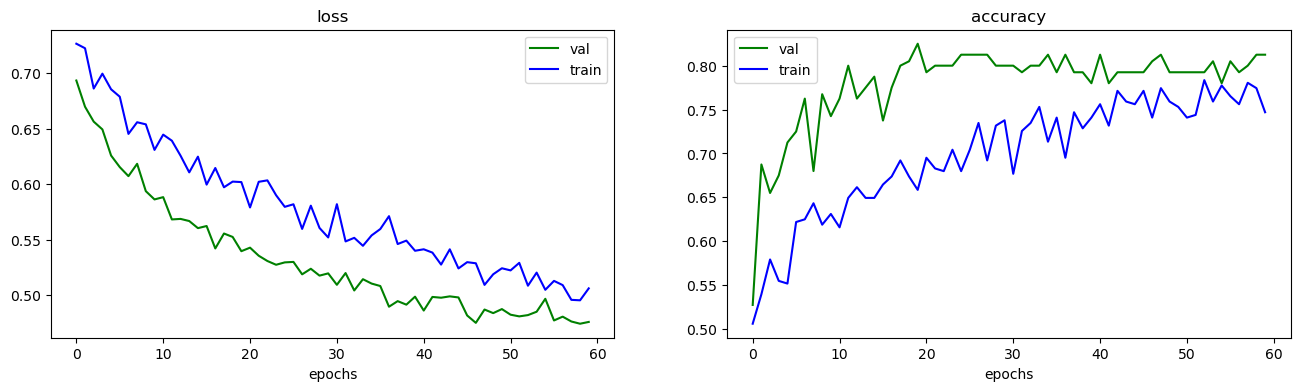

In [119]:
fig, axs = plt.subplots(1,2,figsize=(16,4))
# ax = fig.add_subplot(121)
axs[0].plot(val_loss, 'g') 
axs[0].plot(loss,'b', label = 'train_loss')
axs[0].set_title("loss")
axs[0].set_xlabel("epochs")
axs[0].legend(['val','train'])
# ax2 = fig.add_subplot(122)
axs[1].plot(val_acc, 'g', label = 'val') 
axs[1].plot(acc,'b',label = 'train')
axs[1].set_title("accuracy")
axs[1].set_xlabel("epochs")
axs[1].legend(['val','train'])
plt.show()

In [120]:
def predict_nn(model,inputs,threshold):
    inputs = torch.tensor(inputs.values)
    inputs = inputs.to(torch.float32)
    with torch.no_grad():
        model.eval()
        preds_nn = model(inputs)
        preds_nn = np.array([0 if i<=threshold else 1 for i in preds_nn.detach().numpy()])
    return preds_nn

In [150]:
preds_nn = predict_nn(model,X_test,0.44)
y_test_reshaped = y_test.values.reshape(-1,1)

In [151]:
accuracy_score(y_test_reshaped,preds_nn)

0.8311688311688312

In [152]:
f1_score(y_test_reshaped,preds_nn)

0.8943089430894309

In [153]:
model_scripted = torch.jit.script(model)
model_scripted.save('binary_classifier.pt')

---
итоги

---

In [154]:
print('-'*15+'random forest unbalanced classes'+'-'*15)
print('Test accuracy; {}'.format(accuracy_score(y_test,preds_tree)))
print('Test F1: {}'.format(f1_score(y_test,preds_tree)))
print('-'*16+'random forest balanced classes'+'-'*16)
print('Test accuracy; {}'.format(accuracy_score(y_test,preds_tree_r)))
print('Test F1: {}'.format(f1_score(y_test,preds_tree_r)))
print('-'*21+'nn balanced classes'+'-'*22)
print('Test accuracy; {}'.format(accuracy_score(y_test_reshaped,preds_nn)))
print('Test F1: {}'.format(f1_score(y_test_reshaped,preds_nn)))


---------------random forest unbalanced classes---------------
Test accuracy; 0.8961038961038961
Test F1: 0.9344262295081968
----------------random forest balanced classes----------------
Test accuracy; 0.961038961038961
Test F1: 0.9743589743589743
---------------------nn balanced classes----------------------
Test accuracy; 0.8311688311688312
Test F1: 0.8943089430894309
